In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 18.5 MB/s eta 0:00:00


In [ ]:
#
"""
LOOCV (OOF) model ranking — NO SCALING — warning-free
- Fingerprints: Morgan(ECFP4), MACCS, AtomPairs, Torsion, Avalon, Daylight
- SVR kernels: linear, rbf, sigmoid
- CV: LOOCV via cross_val_predict -> global R² on OOF predictions
- Rank by R² (tie-break: residual std), refit top-K on all data
- Blind predictions: per-model + ensemble
"""

from pathlib import Path
import numpy as np
import pandas as pd

# --- Quiet RDKit logs ---
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg  # modern generator API
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# =========================
# Config
# =========================
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"   # training set (63)
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

# Blind set (set to None to skip)
NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"  # if absent, synthetic labels will be created

FP_SIZE   = 2048
MORGAN_R  = 2   # ECFP4 radius
TOP_K     = 5
OUT_DIR   = Path("outputs_loocv_oof_noscale_clean")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# =========================
# Fingerprint helpers (warning-free)
# =========================
# Generators (bit fingerprints; non-deprecated)
morgan_gen = rfg.GetMorganGenerator(
    radius=MORGAN_R,
    includeChirality=False,
    useBondTypes=True,
    fpSize=FP_SIZE
)
apair_gen = rfg.GetAtomPairGenerator(
    includeChirality=False,
    fpSize=FP_SIZE
)
ttors_gen = rfg.GetTopologicalTorsionGenerator(
    includeChirality=False,
    fpSize=FP_SIZE
)

def fp_bits_morgan(m):   return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m):return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):  return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):    return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m): return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):   return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan":
        fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS":
        fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs":
        fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion":
        fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon":
        fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight":
        fps = [fp_bits_daylight(m) for m in mols]
    else:
        raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([np.asarray(homo, np.float32), np.asarray(lumo, np.float32)])
    return np.hstack([X_bits, E])

def make_model(kernel):  # NO SCALING
    return SVR(kernel=kernel)

def loocv_oof_metrics(model, X, y):
    loo = LeaveOneOut()
    y_hat = cross_val_predict(model, X, y, cv=loo)
    r2   = float(r2_score(y, y_hat))
    rmse = float(np.sqrt(mean_squared_error(y, y_hat)))
    mae  = float(mean_absolute_error(y, y_hat))
    rstd = float(np.std(y - y_hat))
    return r2, rmse, mae, rstd, y_hat

# =========================
# Load training data
# =========================
df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL, HOMO_COL, LUMO_COL]).copy()

# Validate & build mols
mols = [Chem.MolFromSmiles(s) for s in df[SMILES_COL].astype(str)]
valid = [m is not None for m in mols]
df = df.loc[valid].reset_index(drop=True)
mols = [m for m in mols if m is not None]

y    = df[TARGET_COL].astype(float).values
homo = df[HOMO_COL].astype(float).values
lumo = df[LUMO_COL].astype(float).values

# =========================
# LOOCV (OOF) ranking
# =========================
records = []
print("\n=== LOOCV (OOF) ranking — NO SCALING — warning-free ===\n")
for fp_name in FINGERPRINTS:
    X = build_features(mols, fp_name, homo, lumo)
    for kernel in KERNELS:
        model = make_model(kernel)
        r2, rmse, mae, rstd, y_hat = loocv_oof_metrics(model, X, y)
        records.append({
            "fingerprint": fp_name,
            "kernel": kernel,
            "loo_oof_r2": r2,
            "loo_oof_rmse": rmse,
            "loo_oof_mae": mae,
            "loo_oof_resid_std": rstd,
            "n_samples": len(y)
        })
        print(f"{fp_name:10s} | {kernel:7s} -> R2={r2:.4f}  RMSE={rmse:.4f}  MAE={mae:.4f}")

summary_df = pd.DataFrame.from_records(records)
summary_csv = OUT_DIR / "summary_loocv_oof.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"\nSaved LOOCV summary: {summary_csv}")

# Rank: higher R², then lower residual std (stability tie-break)
ranked = summary_df.sort_values(
    by=["loo_oof_r2", "loo_oof_resid_std"],
    ascending=[False, True]
).reset_index(drop=True)

TOP_K = min(TOP_K, len(ranked))
topk = ranked.head(TOP_K).copy()
topk_csv = OUT_DIR / f"top_{TOP_K}_loocv_oof.csv"
topk.to_csv(topk_csv, index=False)
print(f"Saved top-{TOP_K} list: {topk_csv}\n")
print(topk[["fingerprint", "kernel", "loo_oof_r2", "loo_oof_rmse", "loo_oof_mae"]])

# =========================
# Refit top-K on all data
# =========================
print("\n=== Refit top models on all data (NO SCALING) ===")
saved = []
for i, row in topk.iterrows():
    fp, kn = row["fingerprint"], row["kernel"]
    X = build_features(mols, fp, homo, lumo)
    model = make_model(kn)
    model.fit(X, y)
    tag = f"{fp}_{kn}".replace(" ", "")
    path = OUT_DIR / f"final_model_{i+1:02d}_{tag}.joblib"
    dump(model, path)
    saved.append((path, fp, kn))
    print(f"Saved: {path}")

# =========================
# Blind predictions
# =========================
if NEW_CSV is not None:
    print("\n=== Blind predictions (per-model + ensemble) ===")
    new_df = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
    if NEW_LABEL_COL not in new_df.columns:
        new_df[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(new_df))]

    new_mols = [Chem.MolFromSmiles(s) for s in new_df[NEW_SMILES].astype(str)]
    valid_new = [m is not None for m in new_mols]
    new_df = new_df.loc[valid_new].reset_index(drop=True)
    new_mols = [m for m in new_mols if m is not None]
    new_homo = new_df[NEW_HOMO_COL].astype(float).values
    new_lumo = new_df[NEW_LUMO_COL].astype(float).values

    per_model = {}
    for (path, fp, kn) in saved:
        mdl = load(path)
        X_new = build_features(new_mols, fp, new_homo, new_lumo)
        yhat = mdl.predict(X_new)
        per_model[path.stem] = yhat

    per_model_df = pd.DataFrame(per_model)
    per_model_df.insert(0, NEW_LABEL_COL, new_df[NEW_LABEL_COL].values)
    per_model_csv = OUT_DIR / "blind_per_model.csv"
    per_model_df.to_csv(per_model_csv, index=False)
    print(f"Saved per-model blind preds: {per_model_csv}")

    Y = np.column_stack([per_model[k] for k in per_model.keys()])
    ens_df = pd.DataFrame({
        NEW_LABEL_COL: new_df[NEW_LABEL_COL].values,
        "Ensemble_mean": Y.mean(axis=1),
        "Ensemble_median": np.median(Y, axis=1)
    })
    ens_csv = OUT_DIR / "blind_ensemble.csv"
    ens_df.to_csv(ens_csv, index=False)
    print(f"Saved ensemble preds: {ens_csv}")

print("\nDone.")



=== LOOCV (OOF) ranking — NO SCALING — warning-free ===

Morgan     | linear  -> R2=0.2494  RMSE=0.5014  MAE=0.3771
Morgan     | rbf     -> R2=0.2218  RMSE=0.5105  MAE=0.3812
Morgan     | sigmoid -> R2=-0.9877  RMSE=0.8159  MAE=0.6049
MACCS      | linear  -> R2=-0.3784  RMSE=0.6794  MAE=0.5416
MACCS      | rbf     -> R2=0.2681  RMSE=0.4951  MAE=0.3757
MACCS      | sigmoid -> R2=-0.6960  RMSE=0.7536  MAE=0.5559
AtomPairs  | linear  -> R2=0.3944  RMSE=0.4504  MAE=0.3490
AtomPairs  | rbf     -> R2=0.2458  RMSE=0.5026  MAE=0.3693
AtomPairs  | sigmoid -> R2=0.2221  RMSE=0.5104  MAE=0.3698
Torsion    | linear  -> R2=0.4694  RMSE=0.4215  MAE=0.3152
Torsion    | rbf     -> R2=0.2958  RMSE=0.4856  MAE=0.3509
Torsion    | sigmoid -> R2=-1.1150  RMSE=0.8416  MAE=0.6116
Avalon     | linear  -> R2=0.3640  RMSE=0.4615  MAE=0.3572
Avalon     | rbf     -> R2=0.1272  RMSE=0.5406  MAE=0.3917
Avalon     | sigmoid -> R2=0.2640  RMSE=0.4965  MAE=0.3534
Daylight   | linear  -> R2=0.3348  RMSE=0.4720  MAE=0

In [ ]:
#5X5

# -*- coding: utf-8 -*-
"""
Repeated 5x5 CV model ranking — NO SCALING — warning-free
- Fingerprints: Morgan(ECFP4), MACCS, AtomPairs, Torsion, Avalon, Daylight
- SVR kernels: linear, rbf, sigmoid
- CV: RepeatedKFold (5 folds x 5 repeats)
- Metrics: mean±std R2, RMSE, MAE across folds
- Rank by mean R2 (desc), tie-break by R2 std (asc), refit top-K on all data
- Blind predictions: per-model + ensemble (mean & median)
"""

from pathlib import Path
import numpy as np
import pandas as pd

# --- Quiet RDKit logs ---
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg  # modern generator API

from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, r2_score
from joblib import dump, load

# =========================
# Config
# =========================
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"   # training set (63)
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

# Blind set (set to None to skip)
NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"  # if absent, synthetic labels will be created

FP_SIZE   = 2048
MORGAN_R  = 2   # ECFP4 radius
TOP_K     = 5
OUT_DIR   = Path("outputs_repkfold_noscale_clean")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# CV params
CV_FOLDS   = 5
CV_REPEATS = 5
RANDOM_SEED = 0

FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# =========================
# Fingerprint helpers (warning-free)
# =========================
morgan_gen = rfg.GetMorganGenerator(
    radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE
)
apair_gen = rfg.GetAtomPairGenerator(
    includeChirality=False, fpSize=FP_SIZE
)
ttors_gen = rfg.GetTopologicalTorsionGenerator(
    includeChirality=False, fpSize=FP_SIZE
)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan":
        fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS":
        fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs":
        fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion":
        fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon":
        fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight":
        fps = [fp_bits_daylight(m) for m in mols]
    else:
        raise ValueError(fp_name)
    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([np.asarray(homo, np.float32), np.asarray(lumo, np.float32)])
    return np.hstack([X_bits, E])

def make_model(kernel):  # NO SCALING
    return SVR(kernel=kernel)

# =========================
# Load training data
# =========================
df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_COL, HOMO_COL, LUMO_COL]).copy()

mols = [Chem.MolFromSmiles(s) for s in df[SMILES_COL].astype(str)]
valid = [m is not None for m in mols]
df = df.loc[valid].reset_index(drop=True)
mols = [m for m in mols if m is not None]

y    = df[TARGET_COL].astype(float).values
homo = df[HOMO_COL].astype(float).values
lumo = df[LUMO_COL].astype(float).values

# =========================
# Repeated 5x5 CV ranking
# =========================
rkf = RepeatedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED)

# Use cross_validate to collect multiple metrics per fold
scoring = {
    "r2": "r2",
    "rmse": "neg_root_mean_squared_error",  # will be negative; invert sign later
    "mae": "neg_mean_absolute_error",       # will be negative; invert sign later
}

records = []
print("\n=== Repeated 5x5 CV ranking — NO SCALING — warning-free ===\n")
for fp_name in FINGERPRINTS:
    X = build_features(mols, fp_name, homo, lumo)
    for kernel in KERNELS:
        model = make_model(kernel)
        cvres = cross_validate(model, X, y, cv=rkf, scoring=scoring, return_train_score=False)

        r2_scores   = cvres["test_r2"]
        rmse_scores = -cvres["test_rmse"]  # invert sign
        mae_scores  = -cvres["test_mae"]   # invert sign

        row = {
            "fingerprint": fp_name,
            "kernel": kernel,
            "rep_r2_mean":  float(np.mean(r2_scores)),
            "rep_r2_std":   float(np.std(r2_scores)),
            "rep_rmse_mean":float(np.mean(rmse_scores)),
            "rep_rmse_std": float(np.std(rmse_scores)),
            "rep_mae_mean": float(np.mean(mae_scores)),
            "rep_mae_std":  float(np.std(mae_scores)),
            "folds": CV_FOLDS, "repeats": CV_REPEATS,
            "n_samples": len(y),
        }
        records.append(row)
        print(f"{fp_name:10s} | {kernel:7s} -> R2={row['rep_r2_mean']:.4f}±{row['rep_r2_std']:.4f}  "
              f"RMSE={row['rep_rmse_mean']:.4f}  MAE={row['rep_mae_mean']:.4f}")

summary_df = pd.DataFrame.from_records(records)
summary_csv = OUT_DIR / "summary_repkfold.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"\nSaved repeated-CV summary: {summary_csv}")

# Rank by mean R2 (desc), tie-break by R2 std (asc)
ranked = summary_df.sort_values(
    by=["rep_r2_mean", "rep_r2_std"],
    ascending=[False, True]
).reset_index(drop=True)

TOP_K = min(TOP_K, len(ranked))
topk = ranked.head(TOP_K).copy()
topk_csv = OUT_DIR / f"top_{TOP_K}_repkfold.csv"
topk.to_csv(topk_csv, index=False)
print(f"Saved top-{TOP_K} list: {topk_csv}\n")
print(topk[["fingerprint", "kernel", "rep_r2_mean", "rep_r2_std", "rep_rmse_mean", "rep_mae_mean"]])

# =========================
# Refit top-K on all data
# =========================
print("\n=== Refit top models on all data (NO SCALING) ===")
saved = []
for i, row in topk.iterrows():
    fp, kn = row["fingerprint"], row["kernel"]
    X = build_features(mols, fp, homo, lumo)
    model = make_model(kn)
    model.fit(X, y)
    tag = f"{fp}_{kn}".replace(" ", "")
    path = OUT_DIR / f"final_model_{i+1:02d}_{tag}.joblib"
    dump(model, path)
    saved.append((path, fp, kn))
    print(f"Saved: {path}")

# =========================
# Blind predictions
# =========================
if NEW_CSV is not None:
    print("\n=== Blind predictions (per-model + ensemble) ===")
    new_df = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
    if NEW_LABEL_COL not in new_df.columns:
        new_df[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(new_df))]

    new_mols = [Chem.MolFromSmiles(s) for s in new_df[NEW_SMILES].astype(str)]
    valid_new = [m is not None for m in new_mols]
    new_df = new_df.loc[valid_new].reset_index(drop=True)
    new_mols = [m for m in new_mols if m is not None]
    new_homo = new_df[NEW_HOMO_COL].astype(float).values
    new_lumo = new_df[NEW_LUMO_COL].astype(float).values

    per_model = {}
    for (path, fp, kn) in saved:
        mdl = load(path)
        X_new = build_features(new_mols, fp, new_homo, new_lumo)
        yhat = mdl.predict(X_new)
        per_model[path.stem] = yhat

    per_model_df = pd.DataFrame(per_model)
    per_model_df.insert(0, NEW_LABEL_COL, new_df[NEW_LABEL_COL].values)
    per_model_csv = OUT_DIR / "blind_per_model.csv"
    per_model_df.to_csv(per_model_csv, index=False)
    print(f"Saved per-model blind preds: {per_model_csv}")

    Y = np.column_stack([per_model[k] for k in per_model.keys()])
    ens_df = pd.DataFrame({
        NEW_LABEL_COL: new_df[NEW_LABEL_COL].values,
        "Ensemble_mean": Y.mean(axis=1),
        "Ensemble_median": np.median(Y, axis=1)
    })
    ens_csv = OUT_DIR / "blind_ensemble.csv"
    ens_df.to_csv(ens_csv, index=False)
    print(f"Saved ensemble preds: {ens_csv}")

print("\nDone.")



=== Repeated 5x5 CV ranking — NO SCALING — warning-free ===

Morgan     | linear  -> R2=0.1455±0.3021  RMSE=0.4948  MAE=0.3733
Morgan     | rbf     -> R2=0.1573±0.1589  RMSE=0.5073  MAE=0.3877
Morgan     | sigmoid -> R2=-0.3378±0.5390  RMSE=0.6216  MAE=0.4722
MACCS      | linear  -> R2=-0.6274±1.0446  RMSE=0.6532  MAE=0.5257
MACCS      | rbf     -> R2=0.2191±0.1890  RMSE=0.4879  MAE=0.3735
MACCS      | sigmoid -> R2=-0.0435±0.2621  RMSE=0.5584  MAE=0.4281
AtomPairs  | linear  -> R2=0.3393±0.2809  RMSE=0.4330  MAE=0.3451
AtomPairs  | rbf     -> R2=0.2178±0.1628  RMSE=0.4901  MAE=0.3766
AtomPairs  | sigmoid -> R2=0.2181±0.2076  RMSE=0.4868  MAE=0.3659
Torsion    | linear  -> R2=0.3876±0.2402  RMSE=0.4176  MAE=0.3224
Torsion    | rbf     -> R2=0.2628±0.1452  RMSE=0.4744  MAE=0.3585
Torsion    | sigmoid -> R2=-0.3382±0.4491  RMSE=0.6265  MAE=0.4726
Avalon     | linear  -> R2=0.2898±0.3065  RMSE=0.4445  MAE=0.3453
Avalon     | rbf     -> R2=0.1122±0.1651  RMSE=0.5205  MAE=0.3921
Avalon    

In [ ]:
# -*- coding: utf-8 -*-
"""
Binary classification (fixed cutoff=0.3) with Repeated Stratified 5x5 CV
- Fingerprints: Morgan(ECFP4), MACCS, AtomPairs, Torsion, Avalon, Daylight
- Kernels: SVC linear / rbf / sigmoid
- NO SCALING
- Ranks by AUC_mean (desc), AUC_std (asc), then F1_mean (desc)
- Refit top-K on all 63, then run blind predictions + ensemble
"""

from pathlib import Path
import sys, json
import numpy as np
import pandas as pd

# Quiet RDKit logs
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdFingerprintGenerator as rfg  # modern API

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from joblib import dump, load

# ================= CONFIG =================
DATA_XLSX   = "HOMO-LUMO-energies.xlsx"  # train (63)
SMILES_COL  = "Smiles"
TARGET_CONT = "dFF"
HOMO_COL    = "HOMO energy (eV)"
LUMO_COL    = "LUMO energy (eV)"

# Blind set (set to None to skip blind predictions)
NEW_CSV       = "INPUT-NEW-MOLS-correct-HOMOLUMO.csv"
NEW_SMILES    = "Smiles"
NEW_HOMO_COL  = "HOMO (eV)"
NEW_LUMO_COL  = "LUMO (eV)"
NEW_LABEL_COL = "Cmpd Label"   # if absent, synthetic labels will be created

# Fingerprints & kernels
FP_SIZE  = 2048
MORGAN_R = 2  # ECFP4 radius
FINGERPRINTS = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon", "Daylight"]
KERNELS      = ["linear", "rbf", "sigmoid"]

# Cross-validation & selection
CV_FOLDS    = 5
CV_REPEATS  = 5
RANDOM_SEED = 0
TOP_K       = 5

# Fixed scientific cutoff for binary labels
FIXED_CUTOFF = 0.3

# Output directory
OUT_DIR = Path("outputs_cls_repkfold_noscale_clean")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ================= Versions (reproducibility) =================
def log_versions():
    try:
        import sklearn, rdkit, numpy, pandas
        ver = {
            "python": sys.version,
            "sklearn": sklearn.__version__,
            "rdkit": rdkit.__version__,
            "numpy": np.__version__,
            "pandas": pd.__version__,
        }
    except Exception:
        ver = {"python": sys.version}
    with open(OUT_DIR / "versions.json", "w") as f:
        json.dump(ver, f, indent=2)

# ================= Fingerprints (warning-free) =================
morgan_gen = rfg.GetMorganGenerator(radius=MORGAN_R, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)

def fp_bits_morgan(m):    return morgan_gen.GetFingerprint(m)
def fp_bits_atompairs(m): return apair_gen.GetFingerprint(m)
def fp_bits_torsion(m):   return ttors_gen.GetFingerprint(m)
def fp_bits_maccs(m):     return MACCSkeys.GenMACCSKeys(m)               # 166 bits
def fp_bits_daylight(m):  return Chem.RDKFingerprint(m, fpSize=FP_SIZE)  # topological
def fp_bits_avalon(m):    return pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE)

def bitvects_to_numpy(bitvects, fp_size=None):
    if fp_size is None:
        fp_size = len(bitvects[0])
    X = np.zeros((len(bitvects), fp_size), dtype=np.float32)
    for i, bv in enumerate(bitvects):
        DataStructs.ConvertToNumpyArray(bv, X[i])
    return X

def build_features(mols, fp_name, homo, lumo):
    if fp_name == "Morgan":
        fps = [fp_bits_morgan(m) for m in mols]
    elif fp_name == "MACCS":
        fps = [fp_bits_maccs(m) for m in mols]
    elif fp_name == "AtomPairs":
        fps = [fp_bits_atompairs(m) for m in mols]
    elif fp_name == "Torsion":
        fps = [fp_bits_torsion(m) for m in mols]
    elif fp_name == "Avalon":
        fps = [fp_bits_avalon(m) for m in mols]
    elif fp_name == "Daylight":
        fps = [fp_bits_daylight(m) for m in mols]
    else:
        raise ValueError(fp_name)

    X_bits = bitvects_to_numpy(fps, fp_size=len(fps[0]))
    E = np.column_stack([
        np.asarray(homo, np.float32),
        np.asarray(lumo, np.float32)
    ])
    return np.hstack([X_bits, E])

# ================= CV evaluation =================
def evaluate_config_cv(X, y_bin, kernel, n_splits=CV_FOLDS, n_repeats=CV_REPEATS, seed=RANDOM_SEED):
    """
    Repeated Stratified KFold (5x5) with SVC(probability=True).
    Fixed class labels from global cutoff (0.3). Metrics aggregated over 25 splits.
    """
    rng = np.random.RandomState(seed)
    aucs, f1s, accs = [], [], []
    for rep in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng.randint(0, 2**31-1))
        for tr, te in skf.split(X, y_bin):
            Xtr, Xte, ytr, yte = X[tr], X[te], y_bin[tr], y_bin[te]
            clf = SVC(kernel=kernel, probability=True)
            clf.fit(Xtr, ytr)
            p_te = clf.predict_proba(Xte)[:, 1]
            aucs.append(roc_auc_score(yte, p_te))
            # Use 0.5 probability cutoff to make labels (you can change if desired)
            yhat = (p_te >= 0.5).astype(int)
            f1s.append(f1_score(yte, yhat, zero_division=0))
            accs.append(accuracy_score(yte, yhat))
    return {
        "AUC_mean": float(np.mean(aucs)), "AUC_std": float(np.std(aucs)),
        "F1_mean":  float(np.mean(f1s)),  "F1_std":  float(np.std(f1s)),
        "ACC_mean": float(np.mean(accs)), "ACC_std": float(np.std(accs)),
    }

# ================= Blind prediction helpers =================
def predict_blind(models_info, new_df, new_mols, new_homo, new_lumo):
    """
    models_info: list of (path, fingerprint, kernel)
    Returns: per-model DataFrame, and ensemble DataFrame
    """
    per_model = {}
    labels = new_df[NEW_LABEL_COL].values
    for (path, fp, kn) in models_info:
        mdl = load(path)
        X_new = build_features(new_mols, fp, new_homo, new_lumo)
        p = mdl.predict_proba(X_new)[:, 1]
        per_model[Path(path).stem] = p

    # per-model probabilities & labels (0.5 prob threshold)
    per_df = pd.DataFrame(per_model)
    per_df.insert(0, NEW_LABEL_COL, labels)
    # Ensemble
    P = np.column_stack([per_model[k] for k in per_model.keys()])
    ens_mean = P.mean(axis=1)
    ens_median = np.median(P, axis=1)
    ens_vote = (P >= 0.5).astype(int).mean(axis=1) >= 0.5  # majority vote
    ens_df = pd.DataFrame({
        NEW_LABEL_COL: labels,
        "Ensemble_mean":  ens_mean,
        "Ensemble_median": ens_median,
        "Ensemble_vote":  ens_vote.astype(int)
    })
    return per_df, ens_df

# ================= Main =================
def main():
    log_versions()

    # ---- Load training ----
    df = pd.read_excel(DATA_XLSX).dropna(subset=[SMILES_COL, TARGET_CONT, HOMO_COL, LUMO_COL]).copy()
    smiles = df[SMILES_COL].astype(str).tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    ok = [m is not None for m in mols]
    if not all(ok):
        bad_idx = [i for i, t in enumerate(ok) if not t]
        raise ValueError(f"Unparsable SMILES rows: {bad_idx}")
    y_cont = df[TARGET_CONT].astype(float).values
    homo   = df[HOMO_COL].astype(float).values
    lumo   = df[LUMO_COL].astype(float).values

    # ---- Fixed cutoff binarization ----
    y_bin = (y_cont >= FIXED_CUTOFF).astype(int)
    counts = np.bincount(y_bin)
    n0 = int(counts[0]) if len(counts) > 0 else 0
    n1 = int(counts[1]) if len(counts) > 1 else 0
    print(f"✅ Using fixed cutoff = {FIXED_CUTOFF}")
    print(f"Class counts in training (0,1): ({n0}, {n1})")

    # ---- CV over all fingerprint x kernel ----
    records = []
    print("\n=== Repeated Stratified 5x5 CV (NO SCALING) ===\n")
    for fp in FINGERPRINTS:
        X = build_features(mols, fp, homo, lumo)
        for kernel in KERNELS:
            metrics = evaluate_config_cv(X, y_bin, kernel)
            row = {"fingerprint": fp, "kernel": kernel}
            row.update(metrics)
            records.append(row)
            print(f"{fp:10s} | {kernel:7s} -> AUC={row['AUC_mean']:.4f}±{row['AUC_std']:.4f} "
                  f"F1={row['F1_mean']:.4f} ACC={row['ACC_mean']:.4f}")

    cv_df = pd.DataFrame.from_records(records)
    cv_df.to_csv(OUT_DIR / "cv_results.csv", index=False)
    print(f"\nSaved CV results: {OUT_DIR/'cv_results.csv'}")

    # ---- Rank & select top-K ----
    ranked = cv_df.sort_values(
        by=["AUC_mean", "AUC_std", "F1_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)
    topk = ranked.head(min(TOP_K, len(ranked))).copy()
    topk.insert(0, "rank", np.arange(1, len(topk)+1))
    topk.to_csv(OUT_DIR / "top_models.csv", index=False)
    print(f"Saved top models: {OUT_DIR/'top_models.csv'}")
    print(topk[["rank", "fingerprint", "kernel", "AUC_mean", "AUC_std", "F1_mean", "ACC_mean"]])

    # ---- Refit top-K on all data and save models ----
    print("\n=== Refitting top models on all 63 (NO SCALING) ===")
    saved = []
    for i, row in topk.iterrows():
        fp, kn = row["fingerprint"], row["kernel"]
        X_all = build_features(mols, fp, homo, lumo)
        clf = SVC(kernel=kn, probability=True)
        clf.fit(X_all, y_bin)
        tag = f"{fp}_{kn}".replace(" ", "")
        path = OUT_DIR / f"final_model_{int(row['rank']):02d}_{tag}.joblib"
        dump(clf, path)
        saved.append((path, fp, kn))
        print(f"Saved: {path}")

    # ---- Blind predictions (if NEW_CSV provided) ----
    if NEW_CSV is not None:
        print("\n=== Blind predictions (per-model + ensemble) ===")
        bdf = pd.read_csv(NEW_CSV).dropna(subset=[NEW_SMILES, NEW_HOMO_COL, NEW_LUMO_COL]).copy()
        if NEW_LABEL_COL not in bdf.columns:
            bdf[NEW_LABEL_COL] = [f"mol_{i}" for i in range(len(bdf))]
        new_mols = [Chem.MolFromSmiles(s) for s in bdf[NEW_SMILES].astype(str)]
        ok2 = [m is not None for m in new_mols]
        bdf = bdf.loc[ok2].reset_index(drop=True)
        new_mols = [m for m, ok in zip(new_mols, ok2) if ok]
        new_homo = bdf[NEW_HOMO_COL].astype(float).values
        new_lumo = bdf[NEW_LUMO_COL].astype(float).values

        per_df, ens_df = predict_blind(saved, bdf, new_mols, new_homo, new_lumo)
        per_csv = OUT_DIR / "blind_per_model.csv"
        ens_csv = OUT_DIR / "blind_ensemble.csv"
        per_df.to_csv(per_csv, index=False)
        ens_df.to_csv(ens_csv, index=False)
        print(f"Saved blind per-model: {per_csv}")
        print(f"Saved blind ensemble: {ens_csv}")

    print("\nDone.")

if __name__ == "__main__":
    main()


✅ Using fixed cutoff = 0.3
Class counts in training (0,1): (33, 30)

=== Repeated Stratified 5x5 CV (NO SCALING) ===

Morgan     | linear  -> AUC=0.8044±0.0899 F1=0.8014 ACC=0.8195
Morgan     | rbf     -> AUC=0.8506±0.0930 F1=0.6923 ACC=0.7382
Morgan     | sigmoid -> AUC=0.4946±0.2680 F1=0.3703 ACC=0.5172
MACCS      | linear  -> AUC=0.8662±0.0909 F1=0.8070 ACC=0.8128
MACCS      | rbf     -> AUC=0.8321±0.0691 F1=0.7434 ACC=0.7521
MACCS      | sigmoid -> AUC=0.3560±0.1746 F1=0.3128 ACC=0.4056
AtomPairs  | linear  -> AUC=0.9021±0.0853 F1=0.8499 ACC=0.8572
AtomPairs  | rbf     -> AUC=0.8730±0.0988 F1=0.7937 ACC=0.8103
AtomPairs  | sigmoid -> AUC=0.7293±0.2433 F1=0.6682 ACC=0.7200
Torsion    | linear  -> AUC=0.8668±0.0722 F1=0.7909 ACC=0.7964
Torsion    | rbf     -> AUC=0.8676±0.0782 F1=0.7677 ACC=0.7974
Torsion    | sigmoid -> AUC=0.7157±0.1811 F1=0.6361 ACC=0.7008
Avalon     | linear  -> AUC=0.8959±0.0929 F1=0.8241 ACC=0.8477
Avalon     | rbf     -> AUC=0.8686±0.0909 F1=0.7596 ACC=0.7710


<Figure size 500x400 with 0 Axes>

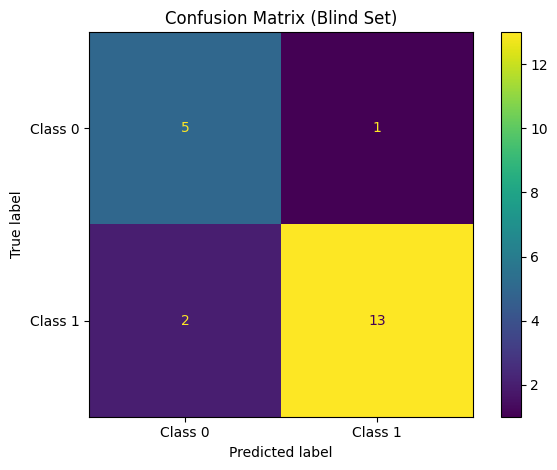

              precision    recall  f1-score   support

     Class 0       0.71      0.83      0.77         6
     Class 1       0.93      0.87      0.90        15

    accuracy                           0.86        21
   macro avg       0.82      0.85      0.83        21
weighted avg       0.87      0.86      0.86        21



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import json

# ---------------- Config ----------------
TRUE_PATH = "expt-dff.xlsx"              # experimental file
PRED_PATH = "outputs_cls_repkfold_noscale_clean/blind_ensemble.csv"         # ensemble predictions
FIXED_CUTOFF = 0.3                       # true dF/F cutoff
PROB_CUTOFF = 0.5                        # predicted probability cutoff

# ---------------- Load true values ----------------
df_true = pd.read_excel(TRUE_PATH, header=None)
df_true.columns = ["Label", "dFF"]
df_true["Label"] = df_true["Label"].astype(str).str.strip()

# ---------------- Load predictions ----------------
df_pred = pd.read_csv(PRED_PATH)
label_col = "Cmpd Label" if "Cmpd Label" in df_pred.columns else "Label"
df_pred.rename(columns={label_col: "Label"}, inplace=True)
df_pred["Label"] = df_pred["Label"].astype(str).str.strip()

# ---------------- Merge ----------------
merged = pd.merge(df_true, df_pred, on="Label", how="inner")

# ---------------- Binarize ----------------
y_true_bin = (merged["dFF"] >= FIXED_CUTOFF).astype(int)
y_pred_prob = merged["Ensemble_mean"].astype(float)   # or Ensemble_median
y_pred_bin = (y_pred_prob >= PROB_CUTOFF).astype(int)

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0","Class 1"])

plt.figure(figsize=(5,4))
disp.plot(values_format="d")
plt.title("Confusion Matrix (Blind Set)")
plt.tight_layout()
plt.savefig("confusion_matrix_blind.png", dpi=200)
plt.show()

# ---------------- Classification Report ----------------
print(classification_report(y_true_bin, y_pred_bin, target_names=["Class 0","Class 1"]))

# ----------
